In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import os
import sys
import matplotlib.pyplot as plt

In [2]:
path_to_pydeformetrica = '/Users/maxime.louis/Documents/pydeformetrica'
sys.path.append(os.path.join(path_to_pydeformetrica, '../'))
from pydeformetrica.src.in_out.xml_parameters import XmlParameters
from pydeformetrica.src.in_out.dataset_functions import create_template_metadata
from pydeformetrica.src.in_out.deformable_object_reader import DeformableObjectReader
from pydeformetrica.src.core.model_tools.attachments.multi_object_attachment import MultiObjectAttachment
from pydeformetrica.src.support.kernels.kernel_functions import create_kernel
from pydeformetrica.src.support.utilities.general_settings import Settings
from src.in_out.array_readers_and_writers import *

In [3]:
path_to_sample = '/Users/maxime.louis/Documents/metric_learning/sample_image/sample_1'
path_to_atlas = '/Users/maxime.louis/Documents/metric_learning/sample_image/'
path_to_output = os.path.join(path_to_atlas, 'output')

In [4]:
# Xml parameters. 
initialized_model_xml_path = os.path.join(path_to_atlas, 'model_after_initialization.xml')


dataset_xml_path = os.path.join(path_to_atlas, 'data_set__sample_1.xml')
optimization_parameters_xml_path = os.path.join(path_to_atlas, 'optimization_parameters_saem.xml')

xml_parameters = XmlParameters()
xml_parameters.read_all_xmls(initialized_model_xml_path, dataset_xml_path, optimization_parameters_xml_path)

>> No initial CP spacing given: using diffeo kernel width of 0
>> State will be saved in file output/pydef_state.p


In [5]:
estimated_trajectory_path = os.path.join(path_to_output, 'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy')
trajectory_parameters = np.load(estimated_trajectory_path)[()]
for key, val in trajectory_parameters.items():
    print(key, val.shape)


p0 (11, 3)
reference_time (11, 1)
v0 (11, 3)
onset_age_variance (11, 1)
log_acceleration_variance (11, 1)
noise_variance (11, 1)
modulation_matrix (11, 6)
metric_parameters (11, 4313)


In [6]:
true_parameters_path = os.path.join(path_to_sample, 'SimulatedData_all_fixed_effects.npy')
true_parameters = np.load(true_parameters_path)[()]
for key, val in true_parameters.items():
    print(key, val.shape)

p0 (3,)
reference_time ()
v0 (3,)
onset_age_variance ()
log_acceleration_variance ()
noise_variance ()
modulation_matrix (3, 2)
metric_parameters (4313,)


#1 Parameters recovery



iteration 4
reference_time 0.0
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
Final relative error for reference_time : nan


/Users/maxime.louis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


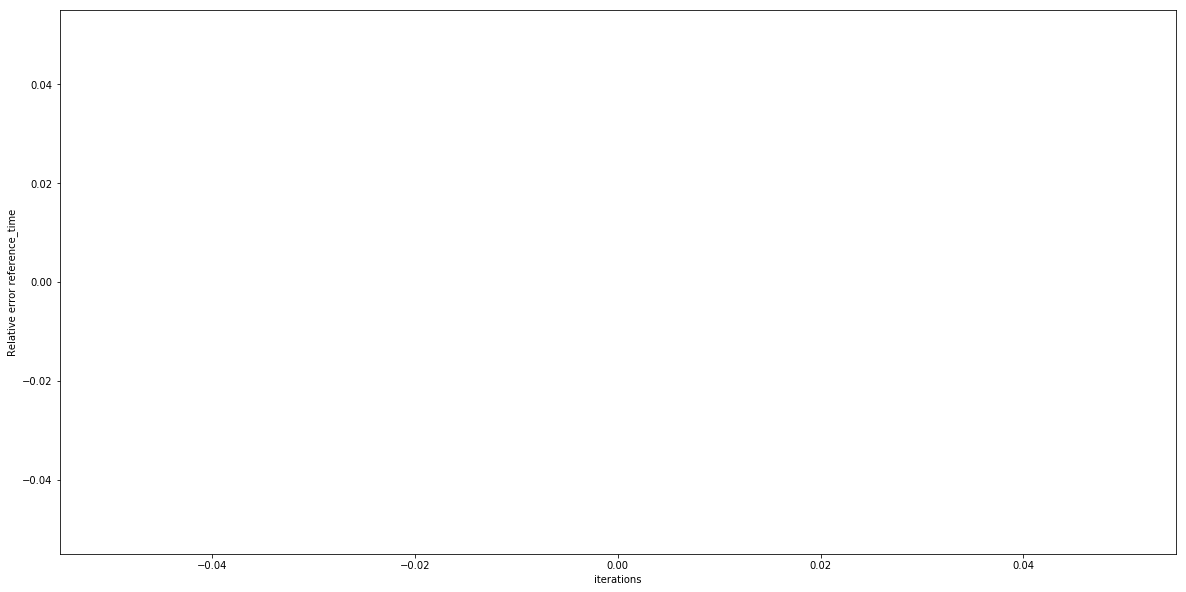

iteration 4
onset_age_variance 1.0
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
Final relative error for onset_age_variance : 0.0


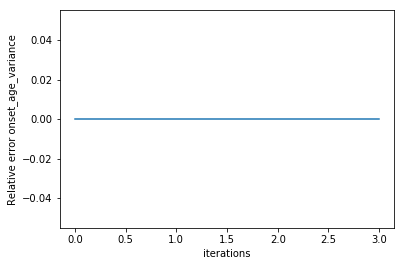

iteration 4
log_acceleration_variance 0.25
[[ 0.25]
 [ 0.25]
 [ 0.25]
 [ 0.25]
 [ 0.25]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]]
Final relative error for log_acceleration_variance : 0.0


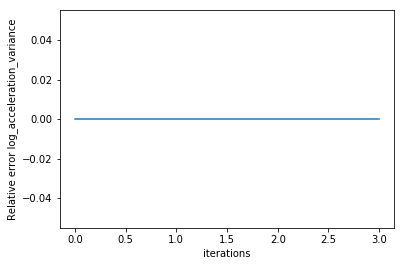

iteration 4
noise_variance 1e-26
[[ 0.00238888]
 [ 0.01024621]
 [ 0.00183321]
 [ 0.00042933]
 [ 0.00022298]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Final relative error for noise_variance : 4.29327993811e+22


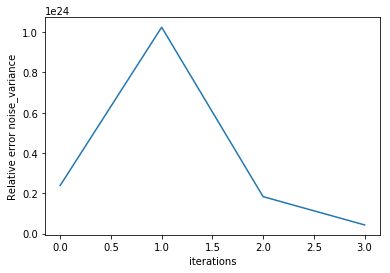

iteration 4
metric_parameters [ 0.195212 -0.417676 -0.191979 ...,  0.400684  0.473846  0.136647]
[[ 0.195212 -0.417676 -0.191979 ...,  0.400684  0.473846  0.136647]
 [ 0.195212 -0.417676 -0.191979 ...,  0.400684  0.473846  0.136647]
 [ 0.195212 -0.417676 -0.191979 ...,  0.400684  0.473846  0.136647]
 ..., 
 [ 0.        0.        0.       ...,  0.        0.        0.      ]
 [ 0.        0.        0.       ...,  0.        0.        0.      ]
 [ 0.        0.        0.       ...,  0.        0.        0.      ]]
Final relative error for metric_parameters : 0.0


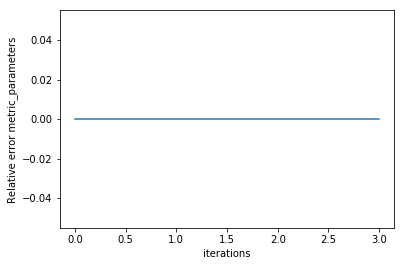

In [18]:
iteration_number = np.max(np.nonzero(trajectory_parameters['p0']))

for key in true_parameters.keys():
    if key not in ['p0', 'v0', 'modulation_matrix']:
        print("iteration", iteration_number)
        print(key, true_parameters[key])
        norm = np.linalg.norm(true_parameters[key])
        relative_error_traj = [np.linalg.norm(elt - true_parameters[key].flatten())/norm for elt in trajectory_parameters[key][:iteration_number]]
        print(trajectory_parameters[key])
        print('Final relative error for', key, ':', relative_error_traj[-1])
        plt.plot(relative_error_traj)
        plt.xlabel('iterations')
        plt.ylabel('Relative error '+ key)
        plt.show()

# 2 Trajectory recovery

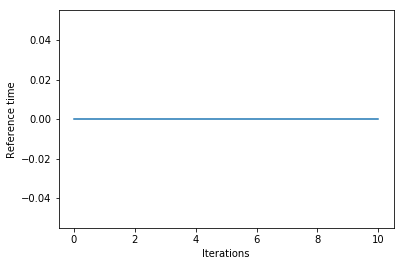

In [8]:
# reference_time.
reference_times = trajectory_parameters['reference_time']
plt.plot(reference_times)
plt.ylabel("Reference time")
plt.xlabel("Iterations")
plt.legend()
plt.show()

Number of nn parameters: 4313


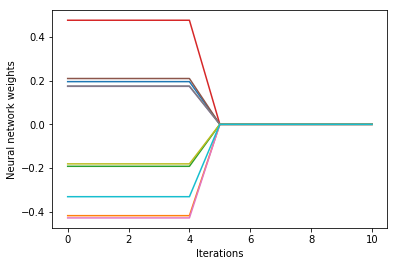

In [9]:
# neural network parameters
nn_parameters = trajectory_parameters['metric_parameters']
print('Number of nn parameters:', len(nn_parameters[0]))
for i in range(10):
    plt.plot(nn_parameters[:, i])
plt.ylabel("Neural network weights")
plt.xlabel("Iterations")
plt.show()
    

# 2. Individual random effects recovery


0.195546986667


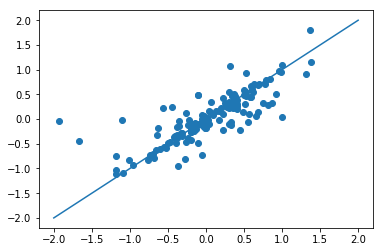

In [10]:
simulated_log_accelerations = np.loadtxt(os.path.join(path_to_sample, 'SimulatedData_log_accelerations.txt'))
estimated_log_accelerations = np.loadtxt(os.path.join(path_to_output, 'LongitudinalMetricModel_log_accelerations.txt'))
relative_error = 0
for i in range(len(simulated_log_accelerations)):
    relative_error += abs(estimated_log_accelerations[i] - simulated_log_accelerations[i])
relative_error /= len(simulated_log_accelerations)
print(relative_error)
plt.scatter(estimated_log_accelerations, simulated_log_accelerations)
plt.plot([-2,2], [-2,2])
plt.show()

0.332536486667


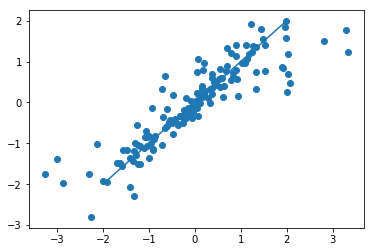

In [11]:
simulated_onset_ages = np.loadtxt(os.path.join(path_to_sample, 'SimulatedData_onset_ages.txt'))
estimated_onset_ages = np.loadtxt(os.path.join(path_to_output, 'LongitudinalMetricModel_onset_ages.txt'))
relative_error = 0
for i in range(len(simulated_onset_ages)):
    relative_error += abs(estimated_onset_ages[i] - simulated_onset_ages[i])
relative_error /= len(simulated_onset_ages)
print(relative_error)
plt.scatter(estimated_onset_ages, simulated_onset_ages)
plt.plot([-2,2], [-2,2])
plt.show()

In [12]:
simulated_sources = np.loadtxt(os.path.join(path_to_sample, 'SimulatedData_sources.txt'))
estimated_sources = np.loadtxt(os.path.join(path_to_output, 'LongitudinalMetricModel_sources.txt'))
relative_error = 0
for i in range(len(simulated_sources)):
    relative_error += np.linalg.norm(estimated_sources[i] - simulated_sources[i])/np.linalg.norm(simulated_sources[i])
relative_error /= len(simulated_sources)
print(relative_error)


0.407408475277


# 3 Absolute times

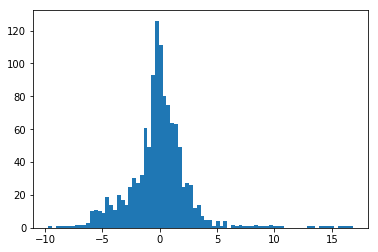

In [13]:
# Absolute times Plotting the histogram for the last observation
abs_times = np.loadtxt(os.path.join(path_to_output, "LongitudinalMetricModel_absolute_times.txt"))
plt.hist(abs_times, bins=80)
plt.show()

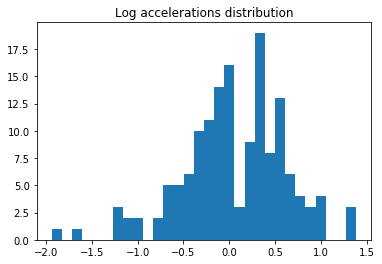

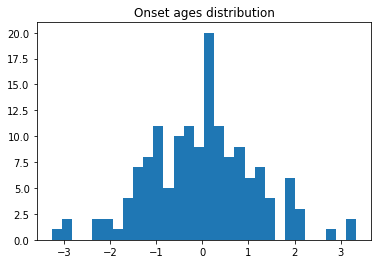

In [14]:
# Last realisations for the alphas and onset ages
log_accelerations = np.loadtxt(os.path.join(path_to_output, "LongitudinalMetricModel_log_accelerations.txt"))
onset_ages = np.loadtxt(os.path.join(path_to_output, "LongitudinalMetricModel_onset_ages.txt"))
plt.hist(log_accelerations, bins=30)
plt.title("Log accelerations distribution")
plt.show()
plt.hist(onset_ages, bins=30)
plt.title("Onset ages distribution")
plt.show()

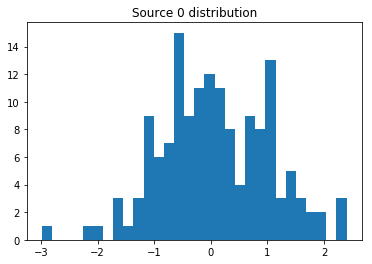

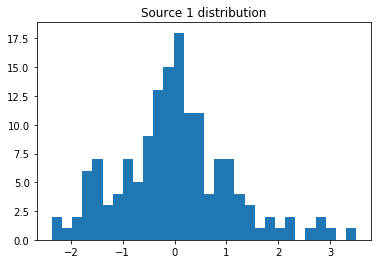

In [15]:
sources = np.loadtxt(os.path.join(path_to_output, "LongitudinalMetricModel_sources.txt"))
if len(sources.shape) == 1:
    sources = sources.reshape(len(sources), 1)
number_of_sources = len(sources[0])
for i in range(len(sources[0])):
    plt.hist(sources[:, i], bins=30)
    plt.title("Source "+str(i)+" distribution")
    plt.show()

# 3 Plotting some images


In [16]:
from PIL import Image
def load_image_trajectory(folder):
    image_paths = [elt for elt in os.listdir(folder) if elt.find('.png') >= 0]
    image_paths = sorted(image_paths, key=(lambda x: int(x[x.find('_t__')+4 : x.find('.png')])))
    to_keep = 5
    image_paths_aux = []
    if len(image_paths) > to_keep:
        stride = int(len(image_paths)/to_keep)
        for i in range(to_keep):
            image_paths_aux.append(image_paths[i*stride])
        image_paths = image_paths_aux
    return [np.array(Image.open(os.path.join(folder, elt)))/255 for elt in image_paths]
    
def plot_images(images):   
    plt.clf()
    f, axes = plt.subplots(1, len(images), figsize=(20, 10))
    max_intensity = np.max(np.array(images))
    min_intensity = np.min(np.array(images))
    for i,ax in enumerate(axes):
        im = ax.imshow(images[i], cmap='inferno', vmin=min_intensity, vmax=max_intensity)    
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.4, 0.01, 0.2])
    f.colorbar(im, cax=cbar_ax)
    plt.show()
        


In [17]:
# Geodesic trajectory
geodesic_folder = os.path.join(path_to_output, 'geodesic_trajectory')
geodesic_images = load_image_trajectory(geodesic_folder)
plot_images(geodesic_images)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# First source
sources_traj = []
for i in range(number_of_sources):
    source_folder = os.path.join(path_to_output, 'parallel_curve_neg_' + str(i))
    sources_traj.append(load_image_trajectory(source_folder))
print(len(sources_traj))
#plot_images(source_images)

In [ ]:
diff_sources_traj =[]
for i in range(number_of_sources):
    diff_sources_traj.append([sources_traj[i][j] - geodesic_images[j] for j in range(len(geodesic_images))])
for elt in diff_sources_traj:
    plot_images(elt)
